# Symptoms
Anosmia and dyspnoea are the major markers of COVID19 verses other diseases. Helen is interested in how these and other symptoms occur with N, S, and RBD responses.

From Helen
> I have updated the details of the clinical history. Anosmia and dyspnoea are reported to be discriminating for those with confirmed COVID disease. Keen to explore whether there are discriminatory symptoms for serum positive and also for whether likely to be N only or N and S.
- \% with each of the different symptoms (and no symptoms ie score 1 on COVID symptoms) in staff who are Ab pos / neg and PcR pos and negative/
- whether there is particular symptoms clustering
- Which symptoms seem to be discriminating for those staff who are swab positive (there were only 12 swab positive at time of illness – most staff with symptoms were not swabbed)
- Which symptoms seem to be discriminating for those staff who are antibody positive
- Linking with the luminex data – is seems that milder symptoms may be associated with only N positive: would it be possible to look at whether there is a difference in symptoms (and demographic, month of reported possible covid illness, duration of symptoms and whether they were N only or N and S positive?

In [11]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%load_ext rpy2.ipython
from rpy2.robjects import r

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
%%R
packages <- c("ggplot2", "dplyr", "diosR", "plot.matrix", "broom", "dotwhisker", "MASS", "MuMIn", "pbkrtest")
lapply(packages, require, character.only=T)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] FALSE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] FALSE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE



In [13]:
os.chdir("/home/david/linux_work/coronavirus_2020/papworth/staff_analysis/data")

In [14]:
%%R
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/david/miniconda3/envs/HICC_datapipe/lib/libmkl_rt.so

locale:
[1] C.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] pbkrtest_0.5-0.1  lme4_1.1-21       Matrix_1.2-17     MuMIn_1.43.17    
[5] MASS_7.3-51.3     broom_0.5.2       plot.matrix_1.5.2 dplyr_1.0.2      
[9] ggplot2_3.1.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       pillar_1.4.7     compiler_3.6.1   nloptr_1.2.2.2  
 [5] plyr_1.8.4       digest_0.6.18    boot_1.3-20      lifecycle_0.2.0 
 [9] tibble_3.0.4     nlme_3.1-139     gtable_0.3.0     lattice_0.20-38 
[13] pkgconfig_2.0.2  rlang_0.4.10     parallel_3.6.1   withr_2.4.1     
[17] generics_0.0.2   vctrs_0.3.6      stats4_3.6.1     grid_3.6.1      
[21] tidyselect_1.1.0 glue_1.4.2       R6_2.4.0  

## Data Preprocessing


In [14]:
%%R

staf <- read.csv("staff_svm_demographic_symptoms_antibodies.csv")
#Remove sero_svm NAs
staf <- filter(staf, !is.na(sero_svm))
# Set sero_svm to TRUE or FALSE
staf$sero_svm <- as.logical(staf$sero_svm)
names(staf)

 [1] "id"               "laminar"          "age"              "sex"             
 [5] "severity"         "ethnicity"        "jobtype"          "location"        
 [9] "note"             "BOOKED.ON.EPIC"   "DATE.TESTED"      "BATCH"           
[13] "RESULTED.ON.EPIC" "bsa"              "n"                "s"               
[17] "rbd"              "lps"              "sero"             "Comment"         
[21] "checked"          "nep"              "bloodspot"        "swabtime"        
[25] "anosmia"          "fatigue"          "myalgia"          "gi"              
[29] "pharyngitis"      "cough"            "dyspnoea"         "fever"           
[33] "headache"         "utri"             "other"            "severity_symp"   
[37] "duration"         "month"            "note_symp"        "sero_svm"        


In [15]:
%%R
for(symptom in c("anosmia","fatigue","myalgia","gi","pharyngitis","cough","dyspnoea","fever","headache","utri")){
    staf[,symptom] <- staf[,symptom] == 1
}

# Data Exploration

In [16]:
%%R

#Proportion With Symptom
prop_w_symp <- function(col){
    #With Symptom
    ws <- sum(col==T, na.rm=T)
    wo <- sum(col==F, na.rm=T)
    prop <- ws/(ws+wo)
    return(prop)
}

#sero_positive
p <- filter(staf, sero_svm==1)[,c("anosmia","fatigue","myalgia","gi","pharyngitis","cough","dyspnoea","fever","headache","utri")]
pp <- apply(p, 2, prop_w_symp)

n <- filter(staf, sero_svm==0)[,c("anosmia","fatigue","myalgia","gi","pharyngitis","cough","dyspnoea","fever","headache","utri")]
np <- apply(n, 2, prop_w_symp)

`summarise()` ungrouping output (override with `.groups` argument)


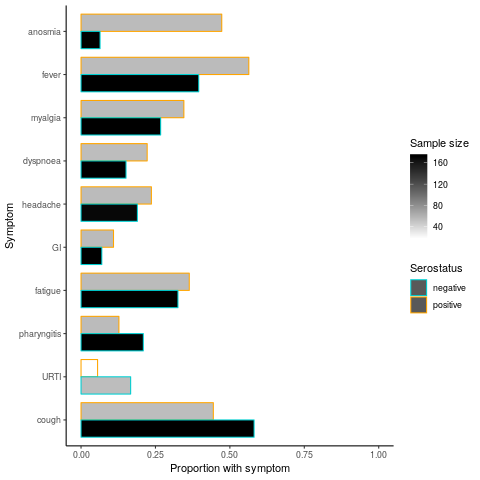

In [17]:
%%R
#Symptom Proportions by serostatus
symprop <- data.frame(
    prop = c(pp,np),
    symptom = c(names(pp), names(np)),
    sero = rep(c('positive', 'negative'), c(length(pp), length(np)))
)

symprop$n <- c(
    apply(p, 2, function(col){sum(!is.na(col))}),
    apply(n, 2, function(col){sum(!is.na(col))})
)


levels(symprop$symptom)[levels(symprop$symptom) == "utri"] <- "URTI"
levels(symprop$symptom)[levels(symprop$symptom) == "gi"] <- "GI"


#Difference in proportions
propdif <- summarise(group_by(symprop, symptom), dif=prop[1]-prop[2])
#use x to order the symptom bars
x <-propdif$symptom[order(propdif$dif)]

ggplot(symprop, aes(x=symptom, colour=sero, fill=n, y=prop)) + 
geom_bar(stat="identity", position="dodge", width=.8)+
scale_colour_manual(values=c("darkturquoise", "orange"), name="Serostatus")+
scale_fill_gradient(low="white", high="black", name="Sample size")+
scale_x_discrete(limits=x)+
ylim(c(0,1))+
xlab("Symptom")+
ylab("Proportion with symptom")+
coord_flip()+
theme_classic()

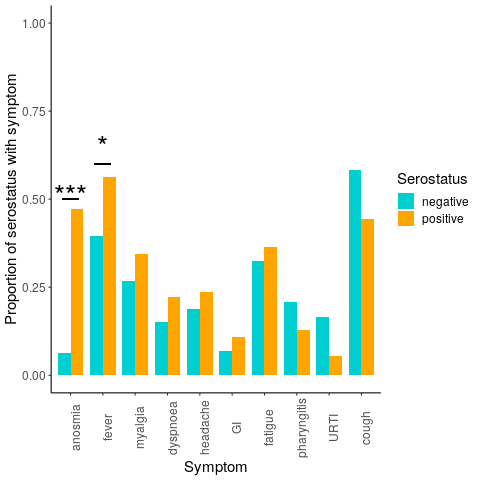

In [36]:
%%R
fig <- 
ggplot(symprop, aes(x=symptom, fill=sero, y=prop)) + 
geom_bar(stat="identity", position="dodge", width=.8)+
scale_fill_manual(values=c("darkturquoise", "orange"), name="Serostatus")+
scale_x_discrete(limits=rev(x))+
geom_segment(aes(x=.75, xend=1.25, y=.5, yend=.5))+
annotate(geom="text",x=1, y=.51, label="***", size=10)+
geom_segment(aes(x=1.75, xend=2.25, y=.6, yend=.6))+
annotate(geom="text",x=2, y=.65, label="*", size=10)+
ylim(c(0,1))+
xlab("Symptom")+
ylab("Proportion of serostatus with symptom")+
# coord_flip()+
theme_classic()+
theme(text=element_text(size=15), axis.text.x=element_text(angle=90))

fig

In [41]:
%%R
ggsave("figure3.jpg", fig, dpi=300)
write.csv(symprop, "symptom proportions.csv", row.names=F)

In [53]:
%%R
# Positive Count
pc <- apply(p, 2, sum, na.rm=T)
# Negative Count
nc <- apply(n, 2, sum, na.rm=T)

#SYMPtom CouNT
sympcnt <- data.frame(
    symptom = c(names(pc), names(nc)),
    count = c(pc,nc),
    sero = rep(c("positive", "negative"), c(length(pc), length(nc)))
)
levels(sympcnt$symptom)[levels(sympcnt$symptom) == "utri"] <- "URTI"
levels(sympcnt$symptom)[levels(sympcnt$symptom) == "gi"] <- "GI"

sympcnt

       symptom count     sero
1      anosmia    26 positive
2      fatigue    20 positive
3      myalgia    19 positive
4           GI     6 positive
5  pharyngitis     7 positive
6        cough    24 positive
7     dyspnoea    12 positive
8        fever    31 positive
9     headache    13 positive
10        URTI     1 positive
11     anosmia    11 negative
12     fatigue    56 negative
13     myalgia    46 negative
14          GI    12 negative
15 pharyngitis    36 negative
16       cough   100 negative
17    dyspnoea    26 negative
18       fever    68 negative
19    headache    32 negative
20        URTI     9 negative


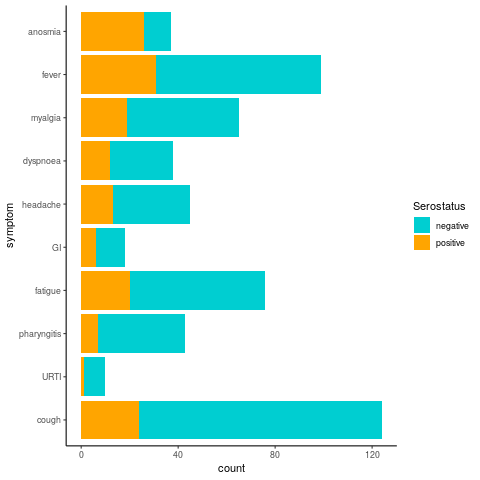

In [79]:
%%R
ggplot(sympcnt, aes(x=symptom, y=count, fill=sero))+
geom_bar(stat="identity")+
scale_fill_manual(values=c("darkturquoise", "orange"), name="Serostatus")+
scale_x_discrete(limits=x)+
coord_flip()+
theme_classic()

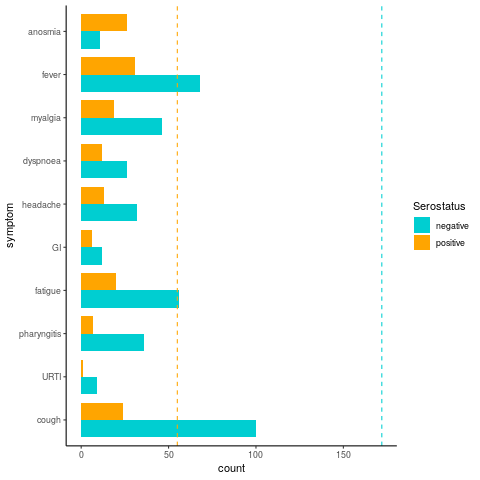

In [78]:
%%R
ggplot(sympcnt, aes(x=symptom, y=count, fill=sero))+
geom_bar(stat="identity", position="dodge", width=0.8)+
geom_hline(yintercept=max(filter(symprop, sero=="positive")$n), lty=2, colour="orange")+
geom_hline(yintercept=max(filter(symprop, sero=="negative")$n), lty=2, colour="darkturquoise")+
scale_fill_manual(values=c("darkturquoise", "orange"), name="Serostatus")+
scale_x_discrete(limits=x)+
coord_flip()+
theme_classic()

In [68]:
%%R
nrow(p)
nrow(n)

[1] 423


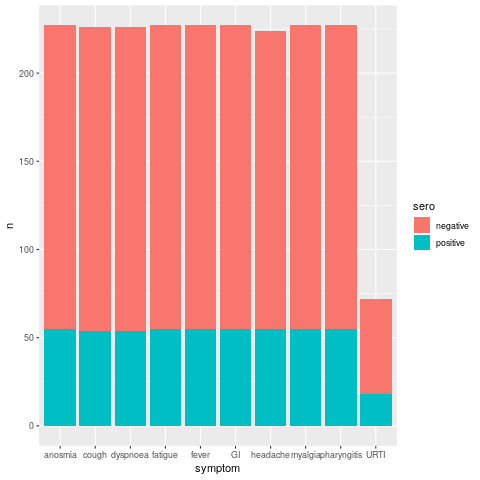

In [34]:
%%R
ggplot(symprop, aes(x=symptom, y=n, fill=sero))+
geom_bar(stat="identity")

In [12]:
%%R
x

 [1] cough       utri        pharyngitis fatigue     gi          headache   
 [7] dyspnoea    myalgia     fever       anosmia    
10 Levels: anosmia cough dyspnoea fatigue fever gi headache ... utri


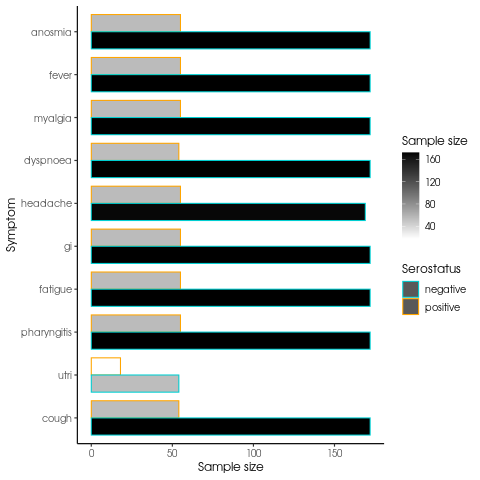

In [10]:
%%R
ggplot(symprop, aes(y=symptom, colour=sero, fill=n, x=n)) + 
geom_bar(stat="identity", position="dodge", width=.8)+
scale_colour_manual(values=c("darkturquoise", "orange"), name="Serostatus")+
scale_fill_gradient(low="white", high="black", name="Sample size")+
scale_y_discrete(limits=x)+
ylab("Symptom")+
xlab("Sample size")+
theme_dios()

## Fit models
We would like to know which symptoms help to distinguish between seropositive and seronegative cases. However to test all of the symptoms would greatly inflate the rate of false positives. Therefore we will use the Benjamini-Hochbergor p-value correction and only test the most promising cases and stop when we get a non-significant result.

In [11]:
%%R
anos0 <- glm(sero_svm ~ 1, family="binomial", data=filter(staf, !is.na(anosmia)))
anos1 <- glm(sero_svm ~ anosmia, family="binomial", data=filter(staf, !is.na(anosmia)))
summary(anos1)


Call:
glm(formula = sero_svm ~ anosmia, family = "binomial", data = filter(staf, 
    !is.na(anosmia)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5576  -0.5755  -0.5755  -0.5755   1.9389  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.7141     0.2017  -8.497  < 2e-16 ***
anosmiaTRUE   2.5743     0.4124   6.242 4.31e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 251.38  on 226  degrees of freedom
Residual deviance: 207.39  on 225  degrees of freedom
AIC: 211.39

Number of Fisher Scoring iterations: 4



In [12]:
%%R
anova(anos0, anos1, test="Chisq")

Analysis of Deviance Table

Model 1: sero_svm ~ 1
Model 2: sero_svm ~ anosmia
  Resid. Df Resid. Dev Df Deviance  Pr(>Chi)    
1       226     251.38                          
2       225     207.39  1   43.996 3.291e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
%%R
PBmodcomp(anos1, anos0, nsim=1000, seed=123)

Bootstrap test; time: 6.17 sec;samples: 1000; extremes: 0;
large : sero_svm ~ anosmia
small : sero_svm ~ 1
         stat df   p.value    
LRT    43.996  1 3.291e-11 ***
PBtest 43.996     0.000999 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


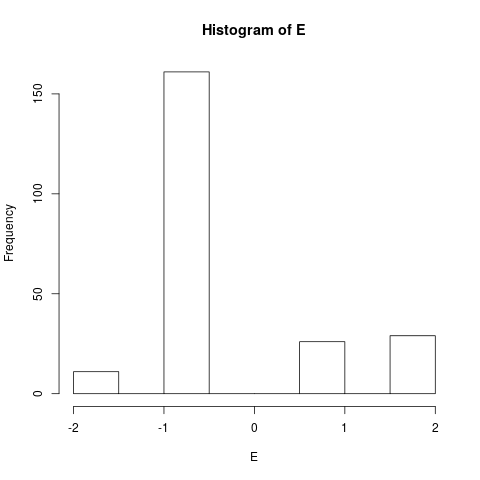

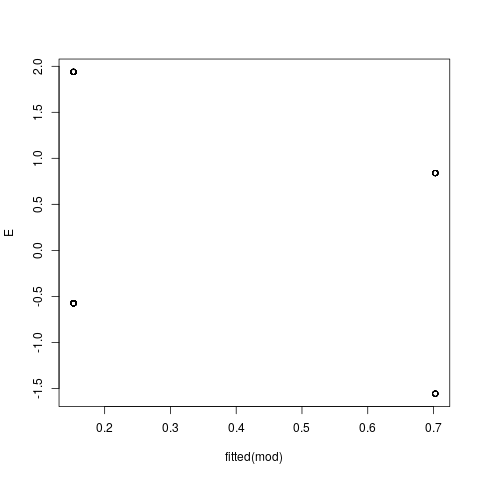

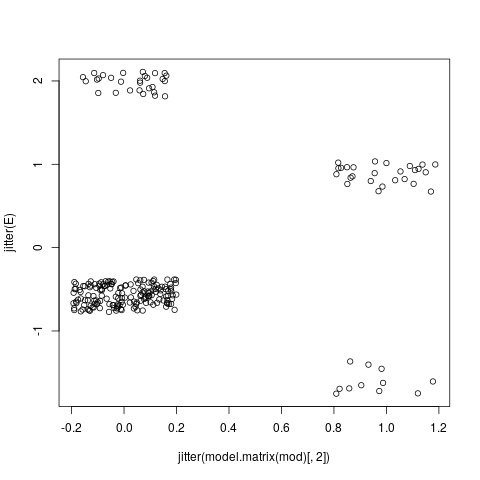

In [14]:
%%R
mod <- anos1

E <- resid(mod)
# par(mfrow())
hist(E)
plot(fitted(mod), E)
plot(jitter(model.matrix(mod)[,2]), jitter(E))

In [15]:
%%R
fever0 <- glm(sero_svm ~ 1, family="binomial", data=filter(staf, !is.na(fever)))
fever1 <- glm(sero_svm ~ fever, family="binomial", data=filter(staf, !is.na(fever)))
print(summary(fever1))

anova(fever0, fever1, test="Chisq")

PBmodcomp(fever1, fever0, nsim=1000, seed=123)


Call:
glm(formula = sero_svm ~ fever, family = "binomial", data = filter(staf, 
    !is.na(fever)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8667  -0.8667  -0.6444  -0.6444   1.8297  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.4663     0.2265  -6.475 9.47e-11 ***
feverTRUE     0.6808     0.3134   2.172   0.0299 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 251.38  on 226  degrees of freedom
Residual deviance: 246.61  on 225  degrees of freedom
AIC: 250.61

Number of Fisher Scoring iterations: 4

Bootstrap test; time: 6.19 sec;samples: 1000; extremes: 30;
large : sero_svm ~ fever
small : sero_svm ~ 1
         stat df p.value  
LRT    4.7692  1 0.02897 *
PBtest 4.7692    0.03097 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R
myal0 <- glm(sero_svm ~ 1, family="binomial", data=filter(staf, !is.na(myalgia)))
myal1 <- glm(sero_svm ~ myalgia, family="binomial", data=filter(staf, !is.na(myalgia)))
print(summary(myal1))

anova(myal0, myal1, test="Chisq")

PBmodcomp(myal1, myal0, nsim=1000, seed=123)


Call:
glm(formula = sero_svm ~ myalgia, family = "binomial", data = filter(staf, 
    !is.na(myalgia)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8316  -0.7090  -0.7090  -0.7090   1.7344  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.2528     0.1890  -6.629 3.38e-11 ***
myalgiaTRUE   0.3686     0.3318   1.111    0.267    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 251.38  on 226  degrees of freedom
Residual deviance: 250.17  on 225  degrees of freedom
AIC: 254.17

Number of Fisher Scoring iterations: 4

Bootstrap test; time: 6.30 sec;samples: 1000; extremes: 300;
large : sero_svm ~ myalgia
small : sero_svm ~ 1
         stat df p.value
LRT    1.2111  1  0.2711
PBtest 1.2111     0.3007


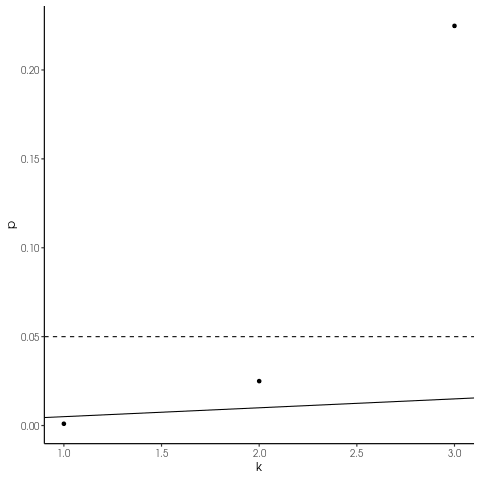

In [17]:
%%R
# Benjamini–Hochberg procedure
df <- data.frame(
    p = c(0.000999, 0.02498, 0.2248),
    k = 1:3
)
df$bh_cut <- 0.05*(df$k/10)
df$bh_pass <- df$p<df$bh_cut
df$bh_sig <- F
df$bh_sig[1:max(which(df$bh_pass))] <- T


ggplot(df, aes(x=k, y=p))+
geom_point()+
# ggplot(data=df, aes(x=k, y=p, colour=bh_sig))+
# geom_point()+
geom_abline(intercept=0, slope=0.05/10)+
geom_hline(yintercept=0.05, lty=2)+
theme_dios()